# Projekt końcowy część 4 - modelowanie (na mniejszej bazie)

KOMENTARZ: przetrenowałam modele na bazie zawierającej 65 kolumn i 45 kolumn. Nie ma różnicy w efektach uczenia, jednak przy mniejszej bazie zajmuje ono mniej czasu.

Zatem poniżej trenowanie na mniejszej bazie. 

## Instrukcja

#### 1. Wykorzystanie trzech algorytmów klasteryzacji - można dowolne, proponuję KMeans, Hierarchiczną i DBScan, jak na zajęciach.

<b> Zajęcia </b>: Uczenie nienadzorowane

<b> Notebook </b>: Uczenie+nienadzorowane.ipynb

#### 2. Uzasadnienie doboru określonej liczby klastrów - dla powyższych metod do dyspozycji mamy metodę łokcia, wskaźnik sylwetkowy i dendrogram

<b> Zajęcia </b>: Uczenie nienadzorowane

<b> Notebook </b>: Uczenie+nienadzorowane.ipynb

#### 3. Sprawdzenie dla otrzymanych klastrów:
  * czy są zbalansowane
  * czym różnią się pożyczkobiorcy w poszczególnych klastrach
  * czy spłacalność w klastrach się różni (najbardziej istotne biznesowo pytanie, jeśli są takie przesłanki to można numer klastra dołączyć nawet jako dodatkową kolumnę i wykorzystać w modelowaniu)
  
  
<b> Zajęcia </b>: Uczenie nienadzorowane

<b> Notebook </b>: Uczenie+nienadzorowane.ipynb  

#### 4. Wytrenowanie 5 różnych modeli - 5 klasyfikatorów, fajnie jakby fundamentalnie się różniły, tzn część bazowała na odległościach (np. regresja logistyczna), a część na decyzjach (np. drzewo decyzyjne/las losowy)

<b> Zajęcia </b>: Wszystkie z modelami oprócz CNN, RNN oraz uczenia nienadzorowanego i bez modeli dla problemów regresyjnych. tzn. np bez pierwszych zajęć o regresji liniowej

<b> Notebook </b>: 
np. metody bazujące na drzewach decyzyjnych: Ensemble+Learning.ipynb, 
regresja logistyczna: Lekcja+2+-+Regresja+logistyczna.ipynb. 
Wiele metod znajdziecie w Feature+eng,+model+selection+&+tuning.ipynb, ale <b>UWAGA!</b> Wy macie problem klasyfikacyjny, więc np. zamiast użycia RandomForestRegressor będziecie użuwać RandomForestClassifier

#### 5. Skompresowanie danych metodą PCA (albo tak żeby zachować xx% zmienności, albo do wybranej liczby komponentów - np. redukcja liczby kolumn ze 100 do 20)

<b> Zajęcia </b>: Uczenie nienadzorowane (część poświęcona PCA)

<b> Notebook </b>: Uczenie+nienadzorowane.ipynb  (część poświęcona PCA)

#### 6. Wytrenowanie tych samych modeli co wcześniej, ale na danych skompresowanych i porównanie otrzymanych wyników.

#### 7. Wybranie jednego, finalnego modelu oraz dokładna jego analiza:
  * Dopasowanie parametrów modelu
  * Walidacja krzyżowa
  * Wygenerowanie krzywej ROC, obliczenie AUROC score i być może innych, dodatkowych metryk
  * Sprawdzenie bias-variance tradeoff - czyli czy model jest zbyt słabo a może nadmiernie dopasowany? Pomocny może być kod z zajęć do generowania "learning_curves"
  * Sprawdzenie istotnych cech - to znaczy na podstawie jakich cech model podejmuje decyzję i czy waszym zdaniem ma to sens
  * Jeśli klasy są niezbalansowane w targecie, można pokusić się o ich zbalansowanie i sprawdzenie wyniku na zbalasnowanych (link do metody: https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)
  
<b> Zajęcia </b>: Metryki ewaluacyjne znajdziecie w zajęciach o regresji logistycznej, czyli logit. Sprawdzenie bias variance trade off i inne głównie w Bias & Variance, Reg, Model selection 

<b> Notebook </b>: Głównie Feature+eng,+model+selection+&+tuning.ipynb, ale metryki i inne rzeczy z podpunktu są też w innych notebookach np. learning_curves w notebooku Learning+Curves+-+Bias-variance+tradeoff.ipynb

## Zaimportowanie danych, obejrzenie bazy

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, skew, pearsonr
import sklearn as sk
from sklearn import metrics
from datetime import datetime, date
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler,power_transform # odpowiednik transformacji logarytmicznej --> ma uczynic rozład naszych danych batdziej gaussowskie
from collections import Counter
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, label_binarize
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, classification_report, accuracy_score, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.svm import SVC
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/projekt_koncowy/Loan_data_after_part_3_mniej_kolumn.csv', index_col = 0)
df.head()

,term,grade,emp_lenght,home_ownership,verification_status,desc,title(consolidation/not),dti,delinq_2yrs,revol_util_in_percent,...,ACC_LowerMid,ACC_HigherMID,ACC_High,inquire_Low,inquire_Mid,inquire_High,revol_bal_Low,revol_bal_LowerMid,revol_bal_HigherMID,revol_bal_High
1,36,2,10.0,2,1,1,0,27.65,0.0,83.7,...,0,0,0,1,0,0,0,0,1,0
2,60,3,1.0,2,2,1,0,1.00,0.0,9.4,...,0,0,0,0,0,1,1,0,0,0
3,36,3,10.0,2,0,0,0,8.72,0.0,98.5,...,0,0,0,1,0,0,1,0,0,0
4,36,3,10.0,2,2,1,0,20.00,0.0,21.0,...,0,1,0,1,0,0,0,1,0,0
5,60,2,1.0,2,2,1,0,17.94,0.0,53.9,...,0,0,1,1,0,0,0,0,0,1


In [ ]:
df.shape

(41498, 45)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41498 entries, 1 to 42479
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   term                      41498 non-null  int64  
 1   grade                     41498 non-null  int64  
 2   emp_lenght                41498 non-null  float64
 3   home_ownership            41498 non-null  int64  
 4   verification_status       41498 non-null  int64  
 5   desc                      41498 non-null  int64  
 6   title(consolidation/not)  41498 non-null  int64  
 7   dti                       41498 non-null  float64
 8   delinq_2yrs               41498 non-null  float64
 9   revol_util_in_percent     41498 non-null  float64
 10  pub_rec_bankruptcies      41498 non-null  float64
 11  loan_status               41498 non-null  int64  
 12  earliest_cr_line_year     41498 non-null  int64  
 13  installment_to_inc        41498 non-null  float64
 14  car   

## Wydzielenie X,y

In [ ]:
# sprawdzam zbalansowanie kolumny targetowej 
df.groupby('loan_status').size()  

loan_status
0     6222
1    35276
dtype: int64

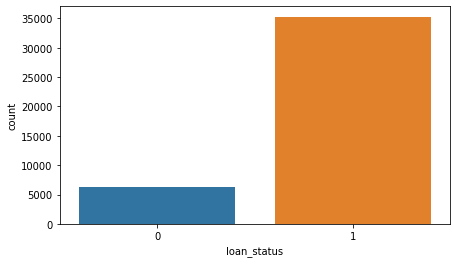

In [ ]:
# wykres zbalansowania kolumny targetowej 
sns.countplot(data=df,x='loan_status')

In [ ]:
# odzielam zmienne od targetu
new_cols = [col for col in df.columns if col != 'loan_status'] 
X = df[new_cols]
y = df['loan_status'] 

In [ ]:
# dzielę na train i test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

## Standaryzacja (scalling)

In [ ]:
# standaryzuję X za pomocą zscora 
X_scaled = X.apply(stats.zscore)

In [ ]:
X_scaled.head()

,term,grade,emp_lenght,home_ownership,verification_status,desc,title(consolidation/not),dti,delinq_2yrs,revol_util_in_percent,...,ACC_LowerMid,ACC_HigherMID,ACC_High,inquire_Low,inquire_Mid,inquire_High,revol_bal_Low,revol_bal_LowerMid,revol_bal_HigherMID,revol_bal_High
1,-0.594068,-0.454285,1.395963,-0.595342,0.241094,0.677562,-0.524085,2.123013,-0.321417,1.217191,...,-0.641892,-0.508773,-0.515446,0.383100,-0.284384,-0.236947,-0.577369,-0.577332,1.732106,-0.577369
2,1.683310,0.248384,-1.208867,-0.595342,1.486416,0.677562,-0.524085,-1.848346,-0.321417,-1.404866,...,-0.641892,-0.508773,-0.515446,-2.610286,-0.284384,4.220358,1.731995,-0.577332,-0.577332,-0.577369
3,-0.594068,0.248384,1.395963,-0.595342,-1.004228,-1.475879,-0.524085,-0.697919,-0.321417,1.739485,...,-0.641892,-0.508773,-0.515446,0.383100,-0.284384,-0.236947,1.731995,-0.577332,-0.577332,-0.577369
4,-0.594068,0.248384,1.395963,-0.595342,1.486416,0.677562,-0.524085,0.983017,-0.321417,-0.995500,...,-0.641892,1.965512,-0.515446,0.383100,-0.284384,-0.236947,-0.577369,1.732106,-0.577332,-0.577369
5,1.683310,-0.454285,-1.208867,-0.595342,1.486416,0.677562,-0.524085,0.676037,-0.321417,0.165545,...,-0.641892,-0.508773,1.940067,0.383100,-0.284384,-0.236947,-0.577369,-0.577332,-0.577332,1.731995


## Klasteryzacja


### KMeans

Szukam na ile klastrów najlepiej podzielić dane

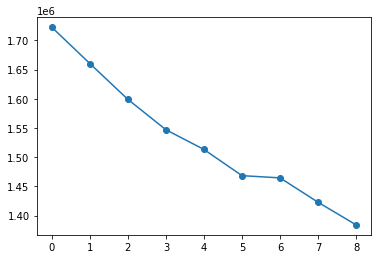

In [ ]:
# metoda łokcia - elbow-curve
ssd = [] # Sum of squared distances
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    
    ssd.append(kmeans.inertia_) #Sum of squared distances
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd, marker = "o" )

Nie widać tu za bardzo podziału na klastry.  Sprawdzam dalej.

Silhouette score (wskaźnik sylwetkowy):

In [ ]:
# Silhouette obliczany jest dla każdej obserwacji w następujący sposób: (a – b)/max(a, b)

# What is considered a good silhouette score?
# The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster 
# to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters

range_n_clusters = [2,3,4,5,6,7,8,9,10]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.058709655839726475
For n_clusters=3, the silhouette score is 0.05800684811312245
For n_clusters=4, the silhouette score is 0.04976252071769625
For n_clusters=5, the silhouette score is 0.0549356006374812
For n_clusters=6, the silhouette score is 0.048544087813595566
For n_clusters=7, the silhouette score is 0.06258809927834211
For n_clusters=8, the silhouette score is 0.07336623145509333
For n_clusters=9, the silhouette score is 0.05910300451558606
For n_clusters=10, the silhouette score is 0.07030731101805723


Ze wskaźnika sylwetkowego wychodzi 8 klastrów, choć silhouette score jest bardzo niski i różnice pomiędzy poszczególnymi liczbami klastrów nie duże.

Dzielę bazę na 8 klastrów:

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_scaled)
kmeans.labels_

array([4, 2, 2, ..., 4, 2, 2], dtype=int32)

Sprawdzam czy spłacalność kredytu różni się w poszczególnych klastrach:

In [ ]:
df['K-Means_Cluster_ID'] = kmeans.labels_

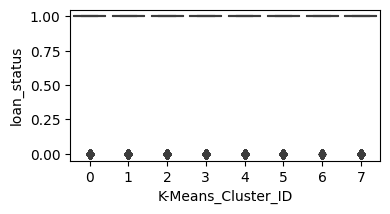

In [ ]:
plt.figure(figsize=(4,2),dpi=100)
sns.boxplot(x='K-Means_Cluster_ID', y='loan_status', data=df)

In [ ]:
df['loan_status'].groupby(df['K-Means_Cluster_ID']).count()

K-Means_Cluster_ID
0    3059
1    4893
2    6389
3    7467
4    7044
5    5593
6     393
7    6660
Name: loan_status, dtype: int64

Wnioski: na podstawie KMeans nie można podzielić bazy na wiarygodne klastry. Spłącalność kredytu nie różni się znacząco w poszczególnych klastrach.

In [ ]:
df.drop(['K-Means_Cluster_ID'], axis =1, inplace = True)

###  DBScan

In [ ]:
clt = DBSCAN(eps=3, metric='euclidean', min_samples=5, n_jobs=-1)
model = clt.fit(X_scaled)

In [ ]:
clt.labels_[:1000] #label "-1"  to szum - próbka, która nie została przydzielona do żadnego klastra

array([ -1,  -1,  -1,  -1,  -1,  -1,  91,  -1,  -1,  -1,  -1,  -1,   0,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 145,  -1,  -1,  -1,  -1,
         1,  -1,  -1,  -1, 122,  -1,   2, 148,   3,  -1,   4,  19,  -1,
         5,  -1,   6, 324,   7,  -1,  -1, 578,  -1,   8,   9, 418,  10,
        -1,  11,  12,  -1, 390,  -1,  13,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  14,  -1,  -1,  -1,  15,  16,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1, 252, 164,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  17,  72,
        -1,  -1, 150,  -1,  18,  -1,  -1,  -1,  19,  20, 158,  -1,  21,
        -1, 140,  -1,  22,  -1,  -1,  23,  -1,  19,  -1,  -1, 171,  -1,
        24,  25,  -1,  26, 263,  27,  28,  29, 452, 566,  -1,  -1,  30,
        -1,  -1,  16,  21,  24,  -1,  -1,  31,  -1,  32,  33,  32,  -1,
        34,  23,  -1,  -1,  -1,  -1,  88,  35,  -1,  -1,  -1,  -1,  32,
        -1,  36,  -1,  37,  -1,  87,  21,  38,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  16,  -1,  -1,  -1,  39,  40,  22,  -1,  -1,  4

Wnioski: Również na podstawie DBScan trudno jest podzielić na wiarygodne klastry. Nawet przy eps = 3 (difoltowo to 0.5) większość próbek jest "-1" (czyli nieprzydzielonych do żadnego klastra).

### Hierarchiczna

Single linkage:

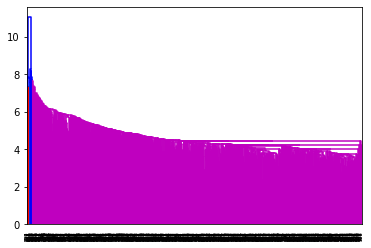

In [ ]:
sl_mergings = linkage(X_scaled.iloc[:1000], method="single", metric='euclidean')
dendrogram(sl_mergings)
plt.show()

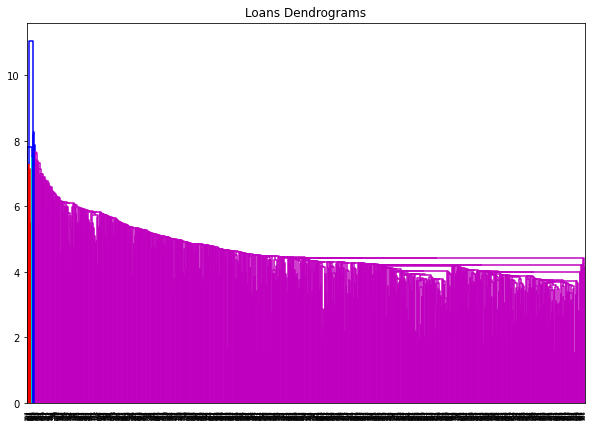

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Loans Dendrograms")
dend = shc.dendrogram(shc.linkage(X_scaled.iloc[:1000]))

Complete linkage:

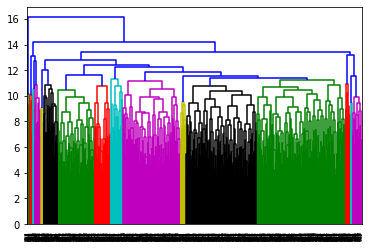

In [ ]:
cl_mergings = linkage(X_scaled.iloc[:1000], method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [ ]:
# dzielę na klastry z complete linkge i sprawdzam równomierność podziału
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=7).reshape(-1, )
cl_cluster_labels 
# słabe wyniki - niezależnie od liczby klastrów podział na klastry nie jest zbalansowany, zazwyczaj najwięcej 0

array([0, 1, 2, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 6, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 3, 3, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0,
       0, 0, 0, 5, 3, 0, 3, 5, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,

Hierarchiczna klasteryzacja nie pozwala na sensowny podział na klastry.

## WNIOSKI: na tej bazie klasteryzacja nie przynosi efektów - żadna z zastosowanych metod nie pozwala na sensowny podział na klastry.

## Skośności

In [ ]:
# sprawdzam które cechy są skośne
def get_skewed_features():
    numeric_feats = df.dtypes[(df.dtypes != "object") & (df.dtypes != "category") ].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) # computes "skewness"
    skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
    return skewed_feats.index

skewed_feats = get_skewed_features()
print("{} heavily skewed features.".format(len(skewed_feats)))
print(skewed_feats)

37 heavily skewed features.
Index(['term', 'grade', 'desc', 'title(consolidation/not)', 'delinq_2yrs',
       'pub_rec_bankruptcies', 'loan_status', 'earliest_cr_line_year',
       'installment_to_inc', 'car', 'credit_card', 'home_improvement',
       'major_purchase', 'other_purpose', 'small_business', 'vacation',
       'Fico_LowerMid', 'Fico_HigherMID', 'Fico_High', 'Inc_Low',
       'Inc_HigherMID', 'Inc_High', 'Loan_Low', 'Loan_LowerMid',
       'Loan_HigherMID', 'Loan_High', 'ACC_Low', 'ACC_LowerMid',
       'ACC_HigherMID', 'ACC_High', 'inquire_Low', 'inquire_Mid',
       'inquire_High', 'revol_bal_Low', 'revol_bal_LowerMid',
       'revol_bal_HigherMID', 'revol_bal_High'],
      dtype='object')


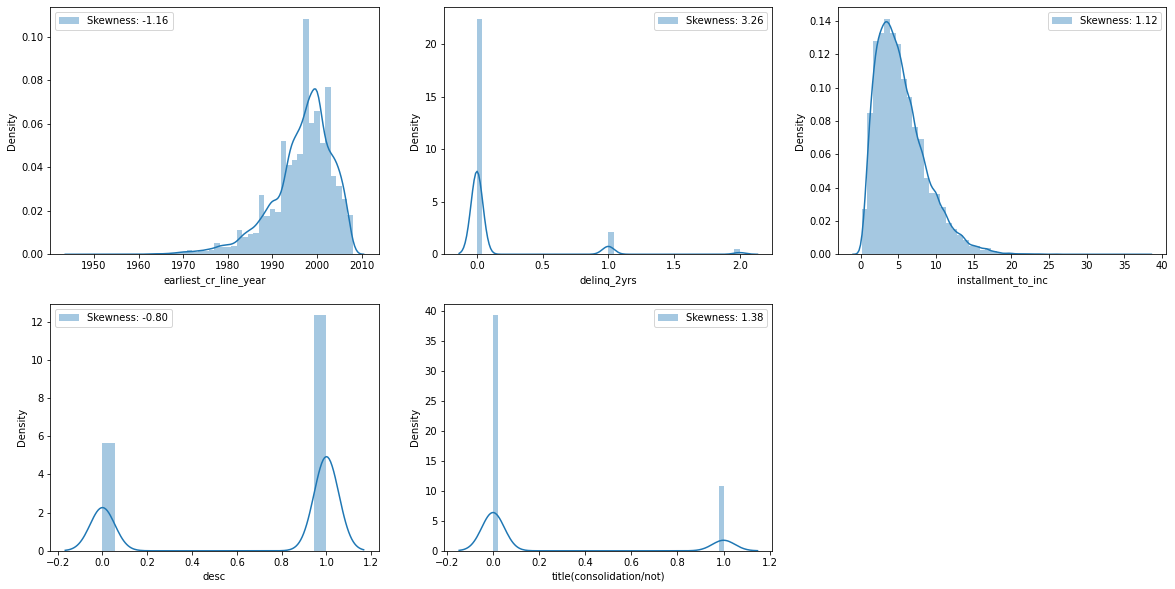

In [ ]:
# wykresy skośności wybranych kolumn
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.distplot(df["earliest_cr_line_year"], label="Skewness: %.2f"%(df["earliest_cr_line_year"].skew()))
plt.legend()

plt.subplot(2,3,2)
sns.distplot(df["delinq_2yrs"], label="Skewness: %.2f"%(df["delinq_2yrs"].skew()))
plt.legend()

plt.subplot(2,3,3)
sns.distplot(df["installment_to_inc"], label="Skewness: %.2f"%(df["installment_to_inc"].skew()))
plt.legend()

plt.subplot(2,3,4)
sns.distplot(df["desc"], label="Skewness: %.2f"%(df["desc"].skew()))
plt.legend()

plt.subplot(2,3,5)
sns.distplot(df["title(consolidation/not)"], label="Skewness: %.2f"%(df["title(consolidation/not)"].skew()))
plt.legend()

In [ ]:
# usuwam skośności w 2 kolumnach: earliest_cr_line_year oraz installment_to_inc

In [ ]:
df[["earliest_cr_line_year"]] = power_transform(df[["earliest_cr_line_year"]], method='yeo-johnson')

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
df[["installment_to_inc"]] = power_transform(df[["installment_to_inc"]], method='yeo-johnson')

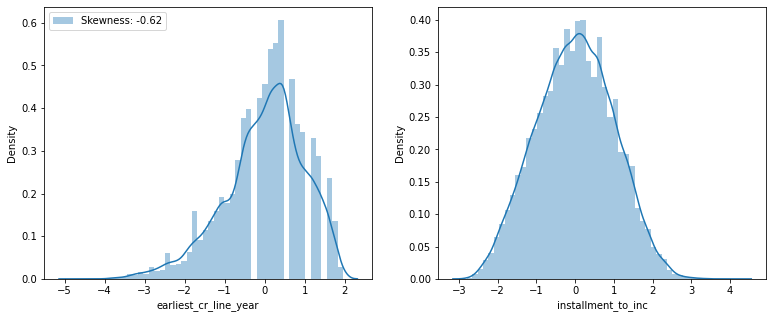

In [ ]:
# wykresy skośności po normalizacji
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df["earliest_cr_line_year"], label="Skewness: %.2f"%(df["earliest_cr_line_year"].skew()))
plt.legend()
plt.subplot(1,3,2)
sns.distplot(df["installment_to_inc"], label="Skewness: %.2f"%(df["installment_to_inc"].skew()))

## Klasyfikacja

In [ ]:
def evaluate(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2),
                       'roc_auc_score': round(metrics.roc_auc_score(prediction,y_test),2)}
    return performance_data

In [ ]:
# dzielę X_scaled na train i test
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.30)

### Regresja logistyczna


In [ ]:
#Logistic regression is best suited to predict the categorical dependent variable. You can use it when the prediction is categorical – for example, 
#true or false, yes or no, or a 0 or 1. 

In [ ]:
model_log_reg = LogisticRegression()

In [ ]:
model_log_reg.fit(X_scaled_train, y_train)

LogisticRegression()

In [ ]:
rl_predictions = model_log_reg.predict(X_scaled_test)

In [ ]:
print(classification_report(y_test,rl_predictions))
log_reg_pr= evaluate(rl_predictions,y_test)
log_reg_pr

              precision    recall  f1-score   support

           0       0.58      0.02      0.04      1850
           1       0.85      1.00      0.92     10600

    accuracy                           0.85     12450
   macro avg       0.72      0.51      0.48     12450
weighted avg       0.81      0.85      0.79     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.72}

In [ ]:
# Accuracy models - how accurate your model's prediction is compared to the true data (TP, TN)
# Precision is defined as the ratio of true positives to the sum of true and false positives (TP, FP).
# Recall	  is defined as the ratio of true positives to the sum of true positives and false negatives (TP, FN).
# F1 Score	is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.
# Support	  is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.
# ROC AUC - interretation: In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition 
#based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

### Decision Tree

In [ ]:
dtree = DecisionTreeClassifier()
# często ogranicza sie głębokość drzewa - liczbę węzłów - zbyt duża liczba węzłów --> tendencja do przeuczenia

In [ ]:
dtree.fit(X_scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
dt_prediction = dtree.predict(X_scaled_test)

In [ ]:
print(classification_report(y_test,dt_prediction))
dtree_pr= evaluate(dt_prediction,y_test)
dtree_pr

              precision    recall  f1-score   support

           0       0.19      0.22      0.21      1850
           1       0.86      0.84      0.85     10600

    accuracy                           0.75     12450
   macro avg       0.53      0.53      0.53     12450
weighted avg       0.76      0.75      0.75     12450



{'accuracy': 0.75, 'f1-score': 0.85, 'roc_auc_score': 0.53}

In [ ]:
# sprawdzam czy accuracy wzrośnie przy większej liczbie foldów --> nie wzrasta
num_folds = 15 # default: 5
kfold = KFold(n_splits=num_folds) # podajemy liczbę foldów
results1 = cross_val_score(dtree,X, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('Standard Deviation: ',results1.std())

Average accuracy:  0.7510006939724395
Standard Deviation:  0.036760061268487805


### Support Vector Machine (SVM)

In [ ]:
model_SVC = SVC()

In [ ]:
model_SVC.fit(X_scaled_train, y_train)

SVC()

In [ ]:
svm_prediction = model_SVC.predict(X_scaled_test)

In [ ]:
print(classification_report(svm_prediction,y_test))
svm_pr = evaluate(svm_prediction,y_test)
svm_pr

              precision    recall  f1-score   support

           0       0.00      0.67      0.00         6
           1       1.00      0.85      0.92     12444

    accuracy                           0.85     12450
   macro avg       0.50      0.76      0.46     12450
weighted avg       1.00      0.85      0.92     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.76}

In [ ]:
cm = confusion_matrix(y_test, svm_prediction)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[    4  1846]
 [    2 10598]]

True Positives(TP) =  4

True Negatives(TN) =  10598

False Positives(FP) =  1846

False Negatives(FN) =  2


### K Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn.fit(X_scaled_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn_prediction = knn.predict(X_scaled_test)

In [ ]:
print(classification_report(knn_prediction,y_test))
knn1_pr = evaluate(knn_prediction,y_test)
knn1_pr

              precision    recall  f1-score   support

           0       0.36      0.21      0.26      3226
           1       0.76      0.87      0.81      9224

    accuracy                           0.70     12450
   macro avg       0.56      0.54      0.54     12450
weighted avg       0.66      0.70      0.67     12450



{'accuracy': 0.7, 'f1-score': 0.81, 'roc_auc_score': 0.54}

### Random Forrest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100) # n_estimators - liczba pojedynczych drzew do klasyfikacji
rf.fit(X_scaled_train, y_train)

RandomForestClassifier()

In [ ]:
rf_prediction = rf.predict(X_scaled_test)

In [ ]:
print(classification_report(rf_prediction,y_test))
rf_pr = evaluate(rf_prediction,y_test)
rf_pr

              precision    recall  f1-score   support

           0       0.01      0.38      0.02        45
           1       1.00      0.85      0.92     12405

    accuracy                           0.85     12450
   macro avg       0.50      0.62      0.47     12450
weighted avg       0.99      0.85      0.92     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.62}

### XGBoost

In [ ]:
xgboost = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xgboost.fit(X_scaled_train,y_train)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
xgboost_prediction = xgboost.predict(X_scaled_test)

In [ ]:
print(classification_report(xgboost_prediction,y_test))
xgb_pr = evaluate(xgboost_prediction,y_test)
xgb_pr

              precision    recall  f1-score   support

           0       0.02      0.45      0.03        65
           1       1.00      0.85      0.92     12385

    accuracy                           0.85     12450
   macro avg       0.51      0.65      0.47     12450
weighted avg       0.99      0.85      0.91     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.65}

### Porównanie klasyfikatorów

In [ ]:
prediction_data={'Model':['Decision Tree',
                          "Regresja Logistyczna",
                          'SVM',
                          'KNN',
                          'Random Forrest Classifier',
                          'XGBoost'
                         ],
                   'F1-score':[dtree_pr['f1-score'],
                              log_reg_pr['f1-score'],
                              svm_pr['f1-score'],
                              knn1_pr['f1-score'],
                              rf_pr['f1-score'],
                              xgb_pr['f1-score']],
                 
                   'Accuracy':[dtree_pr['accuracy'],
                              log_reg_pr['accuracy'],
                              svm_pr['accuracy'],
                              knn1_pr['accuracy'],
                              rf_pr['accuracy'],
                              xgb_pr['accuracy']],
                 
                   'ROC AUC score':[dtree_pr['roc_auc_score'],
                              log_reg_pr['roc_auc_score'],
                              svm_pr['roc_auc_score'],
                              knn1_pr['roc_auc_score'],
                              rf_pr['roc_auc_score'],
                              xgb_pr['roc_auc_score']]
                    }
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table.index = np.arange(1, len(prediction_table) + 1)
prediction_table

,Model,F1-score,Accuracy,ROC AUC score
1,Decision Tree,0.85,0.75,0.53
2,Regresja Logistyczna,0.92,0.85,0.72
3,SVM,0.92,0.85,0.76
4,KNN,0.81,0.70,0.54
5,Random Forrest Classifier,0.92,0.85,0.62
6,XGBoost,0.92,0.85,0.65


Na ten moment najlepsze wyniki osiąga SVM. Srawdzę jeszcze wyniki modeli po wykonaniu PCA oraz zbalansowaniu targetu

### Dodatkowe modele : Gaussian Naive Bayes, Ridge regression, Perceptron, PassiveAggressiveClassifier

Sprawdzam dodatkowe modele, gdyż wyniki powyższych są mało satysfakcjonujące

In [ ]:
def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    start_time = datetime.now()
    clf.fit(X_scaled_train, y_train)
    end_time = datetime.now()
    print('Fit_duration: {}'.format(end_time - start_time))

    start_time = datetime.now()
    pred = clf.predict(X_scaled_test)
    end_time = datetime.now()
    print('Pred_duration: {}'.format(end_time - start_time))

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    clf_name = evaluate(pred,y_test)
    print(evaluate(y_test,pred))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, (end_time - start_time)

results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),#szybszy niż regr.logist)
    (GaussianNB(), 'GaussinanNB'),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive")
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

## PCA

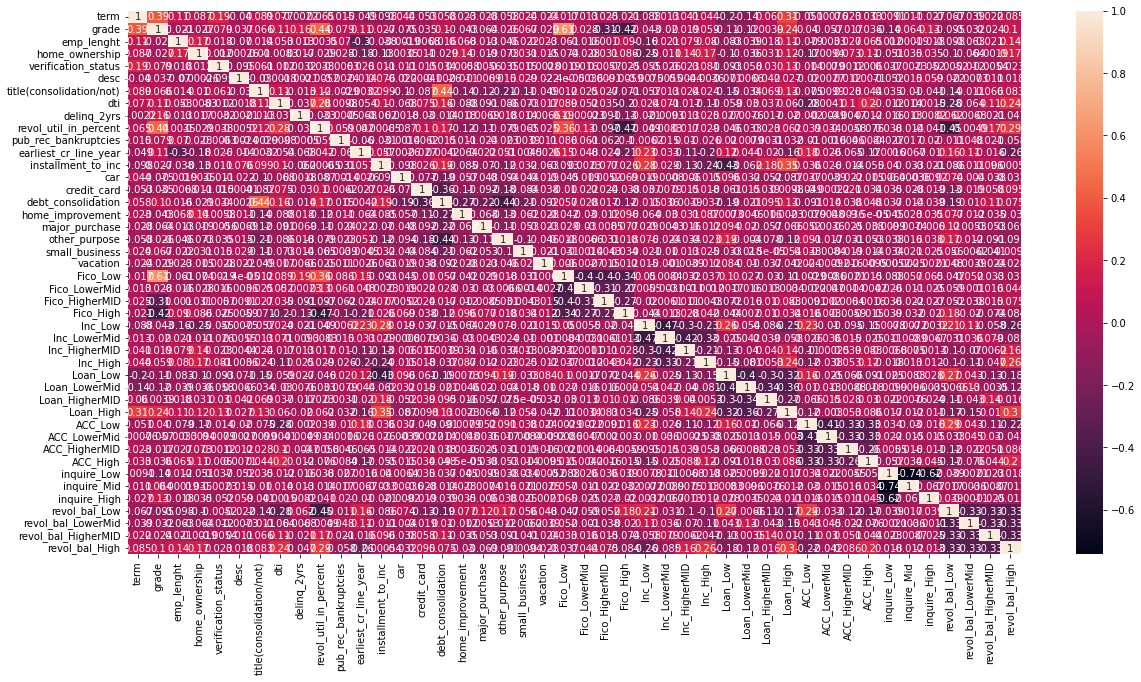

In [ ]:
plt.figure(figsize = (20,10))       
sns.heatmap(X_scaled.corr(),annot = True)

In [ ]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [ ]:
pca.components_[0] # komponenty pierwszeggo elementu  - dla tych nowych komponentów otrzymał następujace nowe wartości

array([-0.17523073, -0.19993953, -0.12584421, -0.13646401, -0.07552079,
       -0.01574163, -0.19063991, -0.22239374,  0.00132856, -0.24934416,
       -0.02183729,  0.15918619, -0.08770197,  0.0861188 , -0.05198723,
       -0.22684202,  0.04003832,  0.11334629,  0.17794647,  0.02315536,
        0.04796806, -0.05686507, -0.04079182, -0.0232283 ,  0.13808875,
        0.23533611, -0.01413986, -0.11899825, -0.13609138,  0.27026874,
        0.08109871, -0.10202196, -0.27696835,  0.23973737, -0.0080598 ,
       -0.09639248, -0.16318234, -0.00568214, -0.003624  ,  0.012711  ,
        0.3327038 ,  0.0896139 , -0.12223174, -0.30008701])

In [ ]:
pca.explained_variance_ratio_ #wariancja komponentów - jaki jest udział poszczególnych kolumn w wywjściowym modelu danych,
#jak dana kolumna odzwierciedla wariancję zmienności danych
# przyjmuje się, ze powinniśmy zachowywać 95% wejściowych danych, 5% się pozybywamy

array([8.13481998e-02, 6.26957290e-02, 5.27216834e-02, 4.27176533e-02,
       4.12053670e-02, 3.62533065e-02, 3.39898739e-02, 3.33361628e-02,
       3.17781535e-02, 3.15222479e-02, 3.05621855e-02, 2.91050205e-02,
       2.84639240e-02, 2.77148969e-02, 2.74576261e-02, 2.67658487e-02,
       2.58596239e-02, 2.55369938e-02, 2.48622583e-02, 2.41038427e-02,
       2.40083945e-02, 2.36346562e-02, 2.31865384e-02, 2.28870968e-02,
       2.22249794e-02, 2.18966168e-02, 2.14527814e-02, 1.91334720e-02,
       1.85525563e-02, 1.76010477e-02, 1.57472885e-02, 1.41343788e-02,
       1.27486900e-02, 1.13508228e-02, 6.34534557e-03, 4.22788905e-03,
       2.86684844e-03, 1.60431036e-32, 4.51279413e-33, 4.18125589e-33,
       2.97978643e-33, 2.77376091e-33, 1.35882887e-33, 1.15603164e-33])

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu
# narastająco - otrzebujemy ok 27 pierwszych kolumn abyn zachować 88 % zmienności danych

array([0.0813482 , 0.14404393, 0.19676561, 0.23948327, 0.28068863,
       0.31694194, 0.35093181, 0.38426798, 0.41604613, 0.44756838,
       0.47813056, 0.50723558, 0.53569951, 0.5634144 , 0.59087203,
       0.61763788, 0.6434975 , 0.6690345 , 0.69389675, 0.7180006 ,
       0.74200899, 0.76564365, 0.78883019, 0.81171728, 0.83394226,
       0.85583888, 0.87729166, 0.89642513, 0.91497769, 0.93257874,
       0.94832603, 0.9624604 , 0.97520909, 0.98655992, 0.99290526,
       0.99713315, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

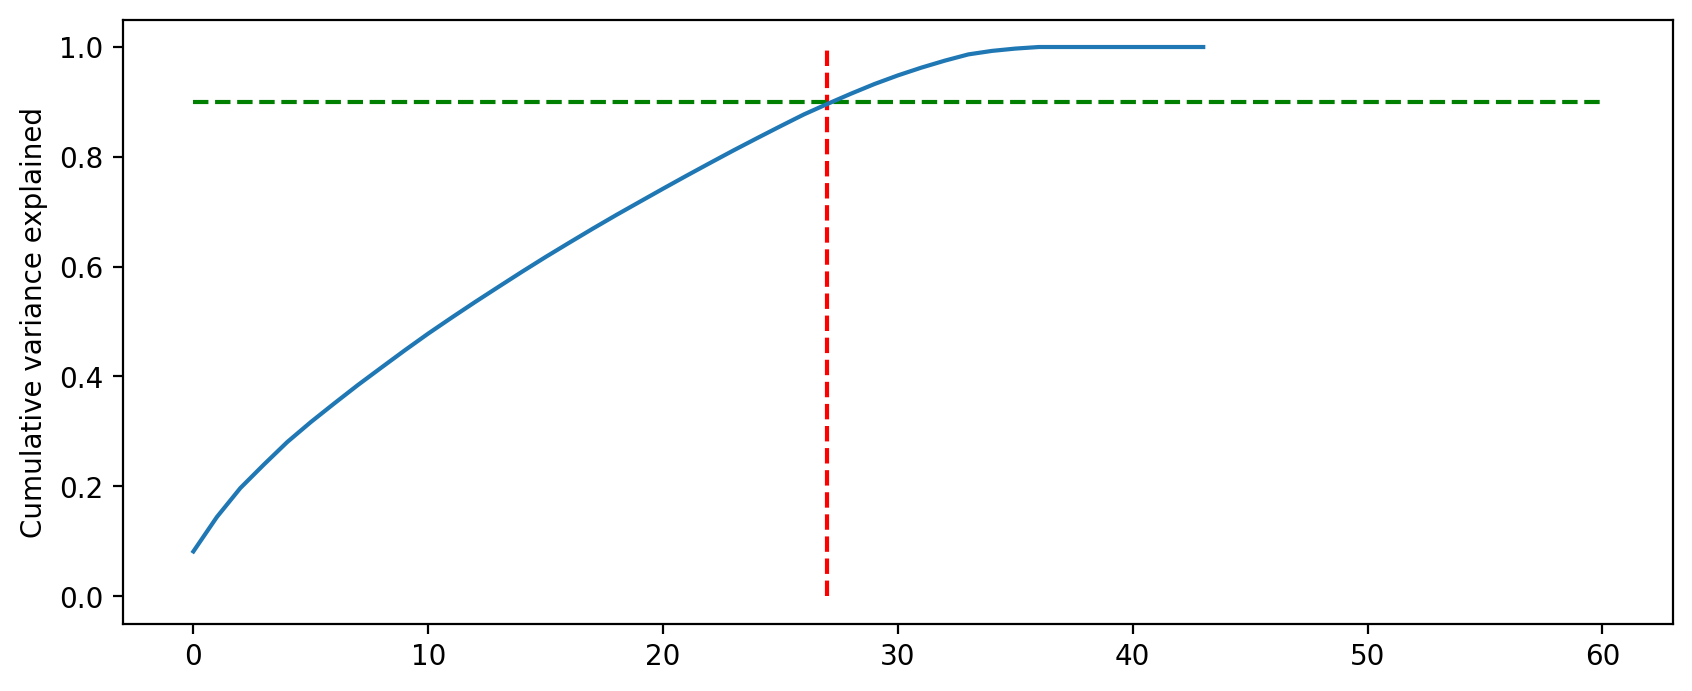

In [ ]:
fig = plt.figure(figsize=[10,4],dpi=200)
plt.vlines(x=27, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=60, xmin=0, colors="g", linestyles="--") # y=% zmienności - może być nieco niższy jesli potrzebujemy wykluczyć jeszcze wiecej kolumn
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [ ]:
pca_final = IncrementalPCA(n_components=27) # zostawiam 42 komponenty, 88% zmienności
X_pca = pca_final.fit_transform(X_scaled)

In [ ]:
print(X_scaled.shape)
print(X_pca.shape)

(41498, 44)
(41498, 27)


In [ ]:
corrmat = np.corrcoef(X_pca.transpose())

In [ ]:
corrmat.shape

(27, 27)

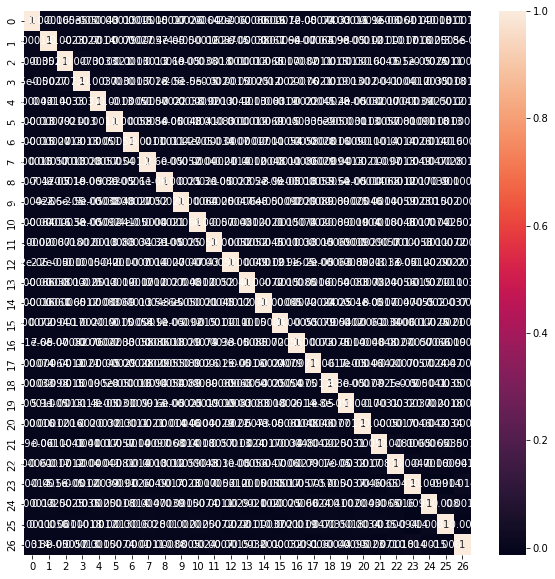

In [ ]:
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, annot=True) # ne ma korelacji -- bardzo dobrze, bo dane się nie dublują - po to robiliśmy to PCA

## Klasyfikacja po wykonaniu PCA

In [ ]:
# dzielę X_pca na train i test
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.30)

### Regresja logistyczna po PCA


In [ ]:
model_log_reg_pca = LogisticRegression()

In [ ]:
model_log_reg_pca.fit(X_pca_train, y_train)

LogisticRegression()

In [ ]:
rl_predictions_pca = model_log_reg_pca.predict(X_pca_test)

In [ ]:
print(classification_report(y_test,rl_predictions_pca))
log_reg_pr_pca= evaluate(rl_predictions_pca,y_test)
log_reg_pr_pca

              precision    recall  f1-score   support

           0       0.49      0.01      0.03      1891
           1       0.85      1.00      0.92     10559

    accuracy                           0.85     12450
   macro avg       0.67      0.51      0.47     12450
weighted avg       0.80      0.85      0.78     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.67}

In [ ]:
log_reg_pr #wyniki przed pca - przypomnienie

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.72}

Wniosek: roc_auc_score jest niższy w przypadku regresji logistycznej przeprowadzonej na bazie po PCA. 

### Decision Tree po PCA

In [ ]:
dtree_pca = DecisionTreeClassifier()

In [ ]:
dtree_pca.fit(X_pca_train,y_train)

DecisionTreeClassifier()

In [ ]:
dt_prediction_pca = dtree_pca.predict(X_pca_test)

In [ ]:
print(classification_report(y_test,dt_prediction_pca))
dtree_pr_pca = evaluate(dt_prediction_pca,y_test)
dtree_pr_pca

              precision    recall  f1-score   support

           0       0.22      0.24      0.23      1891
           1       0.86      0.85      0.86     10559

    accuracy                           0.76     12450
   macro avg       0.54      0.55      0.54     12450
weighted avg       0.77      0.76      0.76     12450



{'accuracy': 0.76, 'f1-score': 0.86, 'roc_auc_score': 0.54}

In [ ]:
dtree_pr

{'accuracy': 0.75, 'f1-score': 0.85, 'roc_auc_score': 0.53}

Nie ma różnicy pomiędzy trenowaniem modelu drzewem decyzyjnym na bazie przed i po PCA

### Support Vector Machine (SVM) po PCA

In [ ]:
model_SVC_pca = SVC()

In [ ]:
model_SVC_pca.fit(X_pca_train,y_train)

SVC()

In [ ]:
svm_prediction_pca = model_SVC_pca.predict(X_pca_test)

In [ ]:
print(classification_report(y_test,svm_prediction_pca))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1856
           1       0.85      1.00      0.92     10594

    accuracy                           0.85     12450
   macro avg       0.43      0.50      0.46     12450
weighted avg       0.72      0.85      0.78     12450



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ponieważ kilka razy z rzędu przez to, że target nie jest jeszcze zbalansowany roc auc nie chce się policzyć to zrobiłam tutaj funkcję, która to obchodzi,
# gdyż zalezy mi na tym by tabelka porównująca kasyfikatory mogła się wygenerować.

def evaluate_1(prediction,y_test): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['1']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2),
                       'roc_auc_score': 'no info'}
    return performance_data
svm_pr_pca = evaluate_1(svm_prediction_pca,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm_pr

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.76}

W przypadku SVM po PCA roc auc score jest niższy, niż przed PCA.

### K Nearest Neighbors (KNN) po PCA

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn.fit(X_pca_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn_prediction_pca = knn.predict(X_pca_test)

In [ ]:
print(classification_report(knn_prediction_pca,y_test))
knn1_pr_pca = evaluate(knn_prediction_pca,y_test)
knn1_pr_pca

              precision    recall  f1-score   support

           0       0.35      0.20      0.26      3234
           1       0.76      0.87      0.81      9216

    accuracy                           0.70     12450
   macro avg       0.55      0.54      0.53     12450
weighted avg       0.65      0.70      0.67     12450



{'accuracy': 0.7, 'f1-score': 0.81, 'roc_auc_score': 0.54}

In [ ]:
knn1_pr

{'accuracy': 0.7, 'f1-score': 0.81, 'roc_auc_score': 0.54}

Nie ma różnicy pomiędzy trenowaniem modelu KNN na bazie przed i po PCA

### Random Forrest Classifier po PCA

In [ ]:
rf = RandomForestClassifier(n_estimators=100) # n_estimators - liczba pojedynczych drzew do klasyfikacji
rf.fit(X_pca_train, y_train)

RandomForestClassifier()

In [ ]:
rf_prediction_pca = rf.predict(X_pca_test)

In [ ]:
print(classification_report(rf_prediction_pca,y_test))
rf_pr_pca = evaluate(rf_prediction_pca,y_test)
rf_pr_pca

              precision    recall  f1-score   support

           0       0.01      0.49      0.02        47
           1       1.00      0.85      0.92     12403

    accuracy                           0.85     12450
   macro avg       0.51      0.67      0.47     12450
weighted avg       0.99      0.85      0.92     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.67}

In [ ]:
rf_pr

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.62}

W przypadku Random Forrest Classifier model po PCA uzyskuje nieco lepszy wynik.

### XGBoost po PCA

In [ ]:
xgboost_pca = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xgboost_pca.fit(X_pca_train,y_train)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
xgboost_prediction_pca = xgboost_pca.predict(X_pca_test)

In [ ]:
print(classification_report(xgboost_prediction_pca,y_test))
xgb_pr_pca = evaluate(xgboost_prediction_pca,y_test)
xgb_pr_pca

              precision    recall  f1-score   support

           0       0.01      0.46      0.01        28
           1       1.00      0.85      0.92     12422

    accuracy                           0.85     12450
   macro avg       0.50      0.66      0.47     12450
weighted avg       1.00      0.85      0.91     12450



{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.66}

In [ ]:
xgb_pr

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.65}

W przypadku XGBoost model po PCA uzyskuje lepszy wynik

### Dodatkowe klasyfikatory po wykonaniu PCA (Gaussian Naive Bayes, Ridge regression, Perceptron, PassiveAggressiveClassifier)

In [ ]:
# dzielę X_pca na train i test
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.30)

In [ ]:
def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    start_time = datetime.now()
    clf.fit(X_pca_train, y_train)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    start_time = datetime.now()
    pred = clf.predict(X_pca_test)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    print(evaluate(y_test,pred))
  
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, (end_time - start_time)

results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),#szybszy niż regr.logist)
    (GaussianNB(), 'GaussinanNB'),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive")
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
Duration: 0:00:00.522369
Duration: 0:00:00.005144
accuracy:   0.848
classification report:
{'f1-score': 0.92, 'accuracy': 0.85, 'roc_auc_score': 0.5}
confusion matrix:
[[    2  1885]
 [    2 10561]]

GaussinanNB
________________________________________________________________________________
Training: 
GaussianNB()
Duration: 0:00:00.036381
Duration: 0:00:00.012784
accuracy:   0.753
classification report:
{'f1-score': 0.85, 'accuracy': 0.75, 'roc_auc_score': 0.59}
confusion matrix:
[[ 690 1197]
 [1881 8682]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
Duration: 0:00:00.130786
Duration: 0:00:00.003083
accuracy:   0.768
classification report:
{'f1-score': 0.86, 'accuracy': 0.77, 'roc_auc_score': 0.53}
confusion matrix:
[[ 348 1539]
 [1344 9219]]

Passive-Aggre

### Porównanie klasyfikatorów po PCA

In [ ]:
prediction_data_all={'Model':['Decision Tree',
                              'LogisticRegression',
                              'SVM',
                              'KNN',
                              'Random Forrest Classifier',
                              'XGBoost'],
                         
                   'F1-score':[dtree_pr['f1-score'],
                              log_reg_pr['f1-score'],
                              svm_pr['f1-score'],
                              knn1_pr['f1-score'],
                              rf_pr['f1-score'],
                              xgb_pr['f1-score']],
                 
                   'Accuracy':[dtree_pr['accuracy'],
                              log_reg_pr['accuracy'],
                              svm_pr['accuracy'],
                              knn1_pr['accuracy'],
                              rf_pr['accuracy'],
                              xgb_pr['accuracy']],
                 
                   'ROC AUC score':[dtree_pr['roc_auc_score'],
                              log_reg_pr['roc_auc_score'],
                              svm_pr['roc_auc_score'],
                              knn1_pr['roc_auc_score'],
                              rf_pr['roc_auc_score'],
                              xgb_pr['roc_auc_score']],
                     
                    'F1-score_pca':[dtree_pr_pca['f1-score'],
                              log_reg_pr_pca['f1-score'],
                              svm_pr_pca['f1-score'],
                              knn1_pr_pca['f1-score'],
                              rf_pr_pca['f1-score'],
                              xgb_pr_pca['f1-score']],
                 
                   'Accuracy_pca':[dtree_pr_pca['accuracy'],
                              log_reg_pr_pca['accuracy'],
                              svm_pr_pca['accuracy'],
                              knn1_pr_pca['accuracy'],
                              rf_pr_pca['accuracy'],
                              xgb_pr_pca['accuracy']],
                 
                   'ROC_AUC_score_pca':[dtree_pr_pca['roc_auc_score'],
                              log_reg_pr_pca['roc_auc_score'],
                              svm_pr_pca['roc_auc_score'],
                              knn1_pr_pca['roc_auc_score'],
                              rf_pr_pca['roc_auc_score'],
                              xgb_pr_pca['roc_auc_score']]
                    }
 
# Create DataFrame
prediction_table_all = pd.DataFrame(prediction_data_all)
prediction_table_all.index = np.arange(1, len(prediction_table_all) + 1)
prediction_table_all

,Model,F1-score,Accuracy,ROC AUC score,F1-score_pca,Accuracy_pca,ROC_AUC_score_pca
1,Decision Tree,0.85,0.75,0.53,0.86,0.76,0.54
2,LogisticRegression,0.92,0.85,0.72,0.92,0.85,0.67
3,SVM,0.92,0.85,0.76,0.92,0.85,no info
4,KNN,0.81,0.70,0.54,0.81,0.70,0.54
5,Random Forrest Classifier,0.92,0.85,0.62,0.92,0.85,0.67
6,XGBoost,0.92,0.85,0.65,0.92,0.85,0.65


## WNIOSKI: najlepsze wyniki uczenia uzyskują XGBoost, LogisticRegression i Random Forrest Classifier po PCA oraz SVM (bez PCA).

## W kolejnym kroku sprawdzam działanie tych modeli po zbalansowaniu targetu.

## Zbalansowanie targetu

In [ ]:
# balansuję target

from imblearn.over_sampling import SMOTE #dodaję tutaj, gdyż z jakiegoś powodu muszę każdorazowo wywoływac ten import, inaczej nie działa

# Sprawdzam zbalansowanie przed wykonaniem SMOTE
print("Przed zbalansowaniem: ", Counter(y_train))

# korzystam z algorytmu SMOTE do zbalansowania danych
SMOTE = SMOTE()
X_SMOTE, y_SMOTE = SMOTE.fit_resample(X_scaled, y)

# Sprawdzam zbalansowanie po wykonaniu SMOTE
print("After oversampling: ",Counter(y_SMOTE))

Przed zbalansowaniem:  Counter({1: 24737, 0: 4311})
After oversampling:  Counter({1: 35276, 0: 35276})


## Sprawdzenie jak modele będą się uczyły na zbalansowanym targecie




In [ ]:
# dzielę X_scaled po zbalansowaniu na train i test
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE,y_SMOTE,test_size=0.30)

### XGBoost na zbalansowanym targecie

In [ ]:
xgboost_SMOTE = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xgboost_SMOTE.fit(X_SMOTE_train,y_SMOTE_train)

XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
xgboost_SMOTE_prediction = xgboost_SMOTE.predict(X_SMOTE_test)

In [ ]:
print(classification_report(xgboost_SMOTE_prediction,y_SMOTE_test))
xgb_SMOTE_pr = evaluate(xgboost_SMOTE_prediction,y_SMOTE_test)
xgb_SMOTE_pr

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8627
           1       1.00      0.84      0.91     12539

    accuracy                           0.90     21166
   macro avg       0.90      0.92      0.90     21166
weighted avg       0.92      0.90      0.90     21166



{'accuracy': 0.9, 'f1-score': 0.91, 'roc_auc_score': 0.92}

In [ ]:
cm = confusion_matrix(y_SMOTE_test, xgboost_SMOTE_prediction)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 8580  2005]
 [   47 10534]]

True Positives(TP) =  8580

True Negatives(TN) =  10534

False Positives(FP) =  2005

False Negatives(FN) =  47


### Support Vector Machine (SVM) na zbalansowanym targecie

In [ ]:
model_SVC_SMOTE = SVC()

In [ ]:
model_SVC_SMOTE.fit(X_SMOTE_train, y_SMOTE_train)

SVC()

In [ ]:
svm_SMOTE_prediction = model_SVC_SMOTE.predict(X_SMOTE_test)

In [ ]:
print(classification_report(svm_SMOTE_prediction,y_SMOTE_test))
svm_SMOTE_pr = evaluate(svm_SMOTE_prediction,y_SMOTE_test)
svm_SMOTE_pr

              precision    recall  f1-score   support

           0       0.83      0.84      0.83     10486
           1       0.84      0.83      0.83     10680

    accuracy                           0.83     21166
   macro avg       0.83      0.83      0.83     21166
weighted avg       0.83      0.83      0.83     21166



{'accuracy': 0.83, 'f1-score': 0.83, 'roc_auc_score': 0.83}

In [ ]:
cm = confusion_matrix(y_SMOTE_test, svm_SMOTE_prediction)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[8769 1834]
 [1717 8846]]

True Positives(TP) =  8769

True Negatives(TN) =  8846

False Positives(FP) =  1834

False Negatives(FN) =  1717


### Random Forrest Classifier na zbalansowanym targecie

In [ ]:
rf_SMOTE = RandomForestClassifier(n_estimators=100) # n_estimators - liczba pojedynczych drzew do klasyfikacji
rf_SMOTE.fit(X_pca_train, y_train)

RandomForestClassifier()

In [ ]:
rf_SMOTE_prediction = rf_SMOTE.predict(X_SMOTE_test)

In [ ]:
print(classification_report(rf_SMOTE_prediction,y_SMOTE_test))
rf_SMOTE_pr = evaluate(rf_SMOTE_prediction,y_SMOTE_test)
rf_SMOTE_pr

              precision    recall  f1-score   support

           0       0.04      0.30      0.08      1602
           1       0.89      0.48      0.63     19564

    accuracy                           0.47     21166
   macro avg       0.47      0.39      0.35     21166
weighted avg       0.83      0.47      0.58     21166



{'accuracy': 0.47, 'f1-score': 0.63, 'roc_auc_score': 0.39}

In [ ]:
rf_pr

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.62}

W przypadku Random Forrest Classifier model po PCA uzyskuje lepszy wynik.

### Regresja logistyczna na zbalansowanym targecie


In [ ]:
model_log_reg_SMOTE = LogisticRegression()

In [ ]:
model_log_reg_SMOTE.fit(X_SMOTE_train, y_SMOTE_train)

LogisticRegression()

In [ ]:
rl_SMOTE_predictions = model_log_reg_SMOTE.predict(X_SMOTE_test)

In [ ]:
print(classification_report(y_SMOTE_test,rl_SMOTE_predictions))
log_reg_SMOTE_pr= evaluate(rl_SMOTE_predictions,y_SMOTE_test)
log_reg_SMOTE_pr

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     10603
           1       0.65      0.65      0.65     10563

    accuracy                           0.66     21166
   macro avg       0.66      0.66      0.66     21166
weighted avg       0.66      0.66      0.66     21166



{'accuracy': 0.66, 'f1-score': 0.65, 'roc_auc_score': 0.66}

In [ ]:
log_reg_pr

{'accuracy': 0.85, 'f1-score': 0.92, 'roc_auc_score': 0.72}

Wniosek: roc_auc_score jest taki sam w przypadku regresji logistycznej przeprowadzonej na bazie po PCA. 

### Porównanie klasyfikatorów po zbalansowaniu targetu

In [ ]:
prediction_data_SMOTE={'Model':['LogisticRegression',
                              'SVM',
                              'Random Forrest Classifier',
                              'XGBoost'],
                         
                   'F1-score':[log_reg_pr['f1-score'],
                              svm_pr['f1-score'],
                              rf_pr['f1-score'],
                              xgb_pr['f1-score']],
                 
                   'Accuracy':[log_reg_pr['accuracy'],
                              svm_pr['accuracy'],
                              rf_pr['accuracy'],
                              xgb_pr['accuracy']],
                 
                   'ROC AUC score':[log_reg_pr['roc_auc_score'],
                              svm_pr['roc_auc_score'],
                              rf_pr['roc_auc_score'],
                              xgb_pr['roc_auc_score']],
                     
                    'F1-score_pca':[log_reg_pr_pca['f1-score'],
                              svm_pr_pca['f1-score'],
                              rf_pr_pca['f1-score'],
                              xgb_pr_pca['f1-score']],
                 
                   'Accuracy_pca':[ log_reg_pr_pca['accuracy'],
                              svm_pr_pca['accuracy'],
                              rf_pr_pca['accuracy'],
                              xgb_pr_pca['accuracy']],
                 
                   'ROC_AUC_score_pca':[ log_reg_pr_pca['roc_auc_score'],
                              svm_pr_pca['roc_auc_score'],
                              rf_pr_pca['roc_auc_score'],
                              xgb_pr_pca['roc_auc_score']],
                       
                    'F1-score_SMOTE':[log_reg_SMOTE_pr['f1-score'],
                              svm_SMOTE_pr['f1-score'],
                              rf_SMOTE_pr['f1-score'],
                              xgb_SMOTE_pr['f1-score']],
                 
                   'Accuracy_SMOTE':[log_reg_SMOTE_pr['accuracy'],
                              svm_SMOTE_pr['accuracy'],
                              rf_SMOTE_pr['accuracy'],
                              xgb_pr['accuracy']],
                 
                   'ROC_AUC_score_SMOTE':[log_reg_SMOTE_pr['roc_auc_score'],
                              svm_SMOTE_pr['roc_auc_score'],
                              rf_SMOTE_pr['roc_auc_score'],
                              xgb_SMOTE_pr['roc_auc_score']],
                    }
 
# Create DataFrame
prediction_table_SMOTE = pd.DataFrame(prediction_data_SMOTE)
prediction_table_SMOTE.index = np.arange(1, len(prediction_table_SMOTE) + 1)
prediction_table_SMOTE

,Model,F1-score,Accuracy,ROC AUC score,F1-score_pca,Accuracy_pca,ROC_AUC_score_pca,F1-score_SMOTE,Accuracy_SMOTE,ROC_AUC_score_SMOTE
1,LogisticRegression,0.92,0.85,0.72,0.92,0.85,0.67,0.65,0.66,0.66
2,SVM,0.92,0.85,0.76,0.92,0.85,no info,0.83,0.83,0.83
3,Random Forrest Classifier,0.92,0.85,0.62,0.92,0.85,0.67,0.63,0.47,0.39
4,XGBoost,0.92,0.85,0.65,0.92,0.85,0.65,0.91,0.85,0.92


## WNIOSKI: Po zbalansowaniu targetu najlepiej uczy się model XGBoost. 

## XGBoost osiąga najlepsze wyniki, dlatego dalej pracuję z tym modelem.



## Analiza i dopracowanie XGBoost:


### Dopasowanie parametrów modelu XGBoost

In [ ]:
# poniżej jeszcze raz wyniki uczenia modelu XGBoost, po PCA, po zbalansowaniu targetu

In [ ]:
xgb_SMOTE_pr

{'accuracy': 0.91, 'f1-score': 0.91, 'roc_auc_score': 0.92}

In [ ]:
xgboost_SMOTE.get_params()

{'alpha': 10,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

Sprawdzam czy zmiana learnig_rate lub innych parametrów poprawi działanie modelu:

In [ ]:
# learning_rate = 0.3 (zamiast 0.1) podnosi f1 o 0,1
xgboost_2nd = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.3, max_depth = 5, alpha = 10, n_estimators = 100)
xgboost_2nd.fit(X_SMOTE_train,y_SMOTE_train)

XGBClassifier(alpha=10, colsample_bytree=0.3, learning_rate=0.3)

In [ ]:
xgboost_2nd_prediction = xgboost_2nd.predict(X_SMOTE_test)

In [ ]:
print(classification_report(xgboost_2nd_prediction,y_SMOTE_test))
xgb_2nd_pr = evaluate(xgboost_2nd_prediction,y_SMOTE_test)
xgb_2nd_pr

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      8811
           1       0.99      0.85      0.92     12355

    accuracy                           0.91     21166
   macro avg       0.91      0.92      0.91     21166
weighted avg       0.92      0.91      0.91     21166



{'accuracy': 0.91, 'f1-score': 0.92, 'roc_auc_score': 0.92}

Sprawdzam, jakie parametry min_child_weight, max_depth, alpha przy learnig_rate = 0.3 będą najlepsze:

In [ ]:
param_test = {
 'min_child_weight':range(1,6,2),
 'max_depth':range(3,10,2),
 'alpha': range(4,14,2)}
gsearch= GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.3, n_estimators=100, 
 colsample_bytree=0.8), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(X_SMOTE_train,y_SMOTE_train)
gsearch.best_params_, gsearch.best_score_

({'alpha': 4, 'max_depth': 3, 'min_child_weight': 5}, 0.9442633265872094)

In [ ]:
xgboost_3rd = xgb.XGBClassifier(colsample_bytree = 0.8, learning_rate = 0.3, max_depth = 3, alpha = 4, n_estimators = 100, min_child_weight = 5)
xgboost_3rd.fit(X_SMOTE_train,y_SMOTE_train)

XGBClassifier(alpha=4, colsample_bytree=0.8, learning_rate=0.3,
              min_child_weight=5)

In [ ]:
xgboost_3rd_prediction = xgboost_3rd.predict(X_SMOTE_test)

In [ ]:
print(classification_report(xgboost_3rd_prediction,y_SMOTE_test))
xgb_3rd_pr = evaluate(xgboost_3rd_prediction,y_SMOTE_test)
xgb_3rd_pr

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      8798
           1       1.00      0.85      0.92     12368

    accuracy                           0.91     21166
   macro avg       0.91      0.92      0.91     21166
weighted avg       0.92      0.91      0.91     21166



{'accuracy': 0.91, 'f1-score': 0.92, 'roc_auc_score': 0.92}

In [ ]:
cm = confusion_matrix(y_SMOTE_test, xgboost_3rd_prediction)
print('Confusion matrix po zmianie parametrów:\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix po zmianie parametrów:

 [[ 8747  1856]
 [   51 10512]]

True Positives(TP) =  8747

True Negatives(TN) =  10512

False Positives(FP) =  1856

False Negatives(FN) =  51


In [ ]:
cm = confusion_matrix(y_SMOTE_test, xgboost_SMOTE_prediction)
print('Confusion matrix przed zmianą parametrów: \n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix przed zmianą parametrów: 

 [[ 8697  1906]
 [   86 10477]]

True Positives(TP) =  8697

True Negatives(TN) =  10477

False Positives(FP) =  1906

False Negatives(FN) =  86


WNIOSKI: zmiany parametrów nie zmieniają wyników uczenia się modelu. Generują jednak nieco mniej FN i FP. Mniejsza liczba FN jest szczególnie istotna, gdyż przy udzielaniu pożyczek istotne jest, aby jak najmniej pożyczek zostało udzielonych osobom, które mają wyższe prawdopodobieństwo niespłacenia (FN).

## Walidacja krzyżowa


In [ ]:
scores = cross_val_score(xgboost_3rd, X_SMOTE, y_SMOTE, cv=5, scoring="roc_auc")
scores
print("%0.2f roc auc score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.93 roc auc score with a standard deviation of 0.13


## Wygenerowanie krzywej ROC



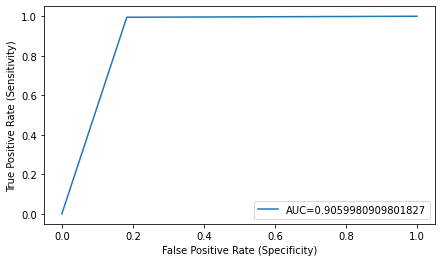

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_SMOTE_test,  xgboost_3rd_prediction)
auc = metrics.roc_auc_score(y_SMOTE_test, xgboost_3rd_prediction)

plt.rcParams["figure.figsize"] = (7,4)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4)
plt.show()  

In [ ]:
# In a ROC curve, a higher X-axis value indicates a higher number of False positives than True negatives.
#  While a higher Y-axis value indicates a higher number of True positives than False negatives

## Sprawdzenie bias-variance tradeoff - czy model nie jest przetrenowany lub zbyt słabo dopsowany? Learning_curves


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
      plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# the more narrow the gap, the lower the variance. The opposite is also true: the wider the gap, the greater the variance
# if the variance is high (wider gap), then the model fits training data too well
# high bias(low variance) (narrow gap) --> underfitting
# high variance (wider gap)--> overfitting 

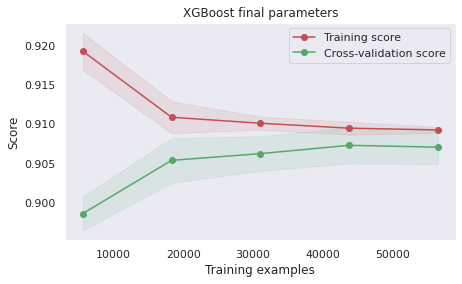

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0) # rozdzielenie na foldy cross validation
plt.rcParams["figure.figsize"] = (7,4)
plot_learning_curve(xgboost_3rd, 'XGBoost final parameters', X_SMOTE, y_SMOTE, n_jobs=4, cv = cv)
plt.show()   # znowu  - dlaczego są takie róznice w zależnosci czy wpisuję xgboost_SMOTE, czy xgboost (powino być xgboost_pca, bo w między czasie zmieniłamnazwę zmiennej)

Wnioski: Model nie jest przetrenowany.

## Sprawdzenie istotnych cech - na podstawie jakich cech model podejmuje decyzję.


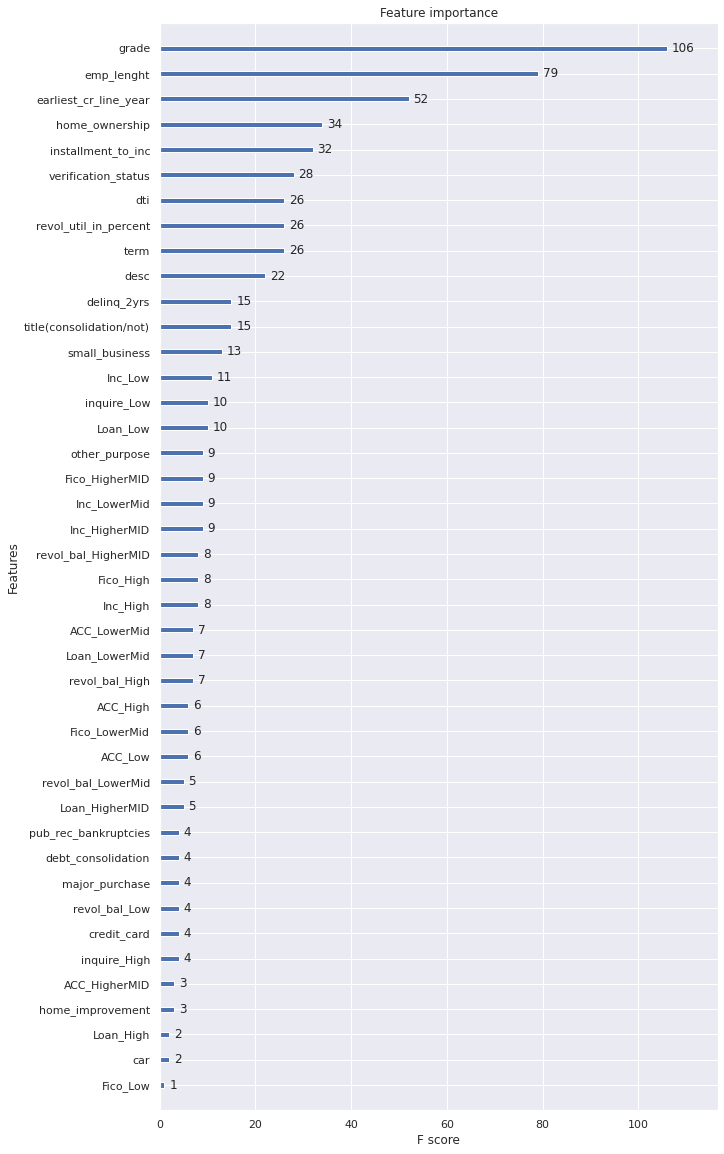

In [ ]:
# plot feature importance
plt.rcParams["figure.figsize"] = (10,20)
plot_importance(xgboost_3rd)
plt.show()

## Zapisanie modelu

In [ ]:
# save the model to disk
filename = 'drive/MyDrive/projekt_koncowy/xboost_final_model.sav'
pickle.dump(xgboost_3rd, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open('drive/MyDrive/projekt_koncowy/xboost_final_model.sav', 'rb'))
result = loaded_model.score(X_SMOTE_test, y_SMOTE_test)
result

0.905981290749315